In [12]:
# Header Files
import io
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import random
import warnings

import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

#from tqdm import tqdm 

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.models import model_from_json


In [13]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

In [14]:

def getIOU(y_true, y_pred, smooth=1):
  tf.cast(y_true, tf.float32)
  tf.cast(y_pred, tf.float32)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

In [15]:
img_size = (256,256)
batch_size = 64

images = "data_images.h5"
masks = "data_masks.h5"

In [16]:
hf1 = h5py.File(images, 'r')
hf2 = h5py.File(masks,'r')

input_image=[]
input_mask=[]

input_image = list(hf1.keys())
input_image = sorted(input_image)
#print(input_image)

input_mask = list(hf2.keys())
input_mask  = sorted(input_mask)
#print(input_mask)

print(len(input_image))
print(len(input_mask))

hf1.close()
hf2.close()


280741
280741


In [17]:
val_samples = 28074
random.Random(1337).shuffle(input_image)
random.Random(1337).shuffle(input_mask)

train_input_img_paths  =  input_image[:-val_samples]
train_target_img_paths =  input_mask[:-val_samples]
val_input_img_paths    =  input_image[-val_samples:]
val_target_img_paths   =  input_mask[-val_samples:]

train_input_img_paths=sorted(train_input_img_paths)
train_target_img_paths=sorted(train_target_img_paths)
val_input_img_paths=sorted(val_input_img_paths)
val_target_img_paths=sorted(val_target_img_paths)

In [18]:
class DataLoad(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x= np.zeros((self.batch_size, 256,256,3), dtype=np.uint8)
        for j, path in enumerate(batch_input_img_paths):
            h5 = h5py.File(images, 'r')
            data=h5.get(path)
            data=np.array(data)
            img = Image.open(io.BytesIO(data))
            img=np.array(img)
            img=resize(img, (256,256), mode='constant',  preserve_range=True)
            x[j] = img
        
        y=np.zeros((self.batch_size, 256, 256, 1), dtype=np.bool)
        for j, path in enumerate(batch_target_img_paths):
            mask = np.zeros((256,256, 1), dtype=np.bool)
            h51=h5py.File(masks,'r')
            data=h51.get(path)
            data=np.array(data)
            mask_=Image.open(io.BytesIO(data))
            
            mask_=np.array(mask_)
            mask_ = np.expand_dims(resize(mask_, (256,256), mode='constant',preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_) 
            y[j]=mask
            
           
        return x, y
    




train_gen = DataLoad(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataLoad(batch_size, img_size, val_input_img_paths, val_target_img_paths)

print(len(train_gen))
print(len(val_gen))


3947
438


In [19]:
inputs = tf.keras.layers.Input((256,256,3))
s= tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',getIOU])
#model.summary()

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('model_weights.h5', verbose=1, save_best_only=True)]

results = model.fit(train_gen,epochs=10,batch_size=64, validation_data=val_gen,callbacks=callbacks)


print(results)
model_json = model.to_json()

with open("model_weights.json", "w") as json_file:
    json_file.write(model_json)
model.save("model_weights_final.h5")
print("Model Saved")


Epoch 1/10
3947/3947 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.8904 - getIOU: 0.5763
Epoch 00001: val_loss improved from inf to 0.18898, saving model to model_weights.h5
3947/3947 [==============================] - 2986s 756ms/step - loss: 0.2499 - accuracy: 0.8904 - getIOU: 0.5763 - val_loss: 0.1890 - val_accuracy: 0.9213 - val_getIOU: 0.6487
Epoch 2/10
3947/3947 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9284 - getIOU: 0.6764
Epoch 00002: val_loss improved from 0.18898 to 0.15923, saving model to model_weights.h5
3947/3947 [==============================] - 2879s 729ms/step - loss: 0.1726 - accuracy: 0.9284 - getIOU: 0.6764 - val_loss: 0.1592 - val_accuracy: 0.9343 - val_getIOU: 0.6956
Epoch 3/10
3947/3947 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9346 - getIOU: 0.6986
Epoch 00003: val_loss improved from 0.15923 to 0.14583, saving model to model_weights.h5
3947/3947 [=============================

In [22]:
from tensorflow.keras.models import load_model
model=load_model('building_weights.h5',custom_objects={'getIOU':getIOU})
print('Model Loaded')

Model Loaded


In [27]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import h5py
import matplotlib.pyplot as plt

IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FC5187995F8>


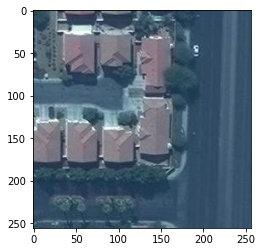

In [28]:
X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
img=Image.open('000000000089.jpg')
print(img)
plt.imshow(img)
img=np.array(img)
X_test[0] = img


In [29]:
preds_test=model.predict(X_test, verbose=1)
print('Prediction:- ')
print(preds_test)
print(preds_test.shape)
print(preds_test.max(),preds_test.min())

1/1 [==============================] - 0s 10ms/step
Prediction:- 
[[[[0.05712774]
   [0.03459737]
   [0.02804598]
   ...
   [0.00260639]
   [0.00244356]
   [0.00697397]]

  [[0.02871939]
   [0.02878295]
   [0.02557086]
   ...
   [0.00280128]
   [0.00301376]
   [0.00386138]]

  [[0.01979197]
   [0.02091461]
   [0.01763825]
   ...
   [0.00153737]
   [0.00138579]
   [0.00133399]]

  ...

  [[0.0183643 ]
   [0.0189846 ]
   [0.01365333]
   ...
   [0.00204667]
   [0.00328628]
   [0.00312719]]

  [[0.02882297]
   [0.02615002]
   [0.01754579]
   ...
   [0.00272827]
   [0.00385798]
   [0.004749  ]]

  [[0.04985167]
   [0.03029523]
   [0.02032249]
   ...
   [0.00215778]
   [0.00390308]
   [0.01075258]]]]
(1, 256, 256, 1)
0.9984977 1.1882504e-06


In [30]:
preds_test = (preds_test > 0.5).astype(np.uint8)
print('Prediction:- ')
print(preds_test)
print(preds_test.shape)
print(preds_test.max(),preds_test.min())


Prediction:- 
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]
(1, 256, 256, 1)
1 0


In [31]:
mask=preds_test[0]
print('Mask:-')
print(mask)
print(mask.shape)
print(mask.max(),mask.min())

for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i][j] == 1:
                    mask[i][j] = 255
                else:
                    mask[i][j] = 0

Mask:-
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]
(256, 256, 1)
1 0


Output Image:- 
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(256, 256, 3)


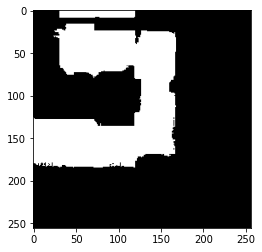

In [32]:
merged_image = cv2.merge((mask,mask,mask))
print('Output Image:- ')
print(merged_image)
print(merged_image.shape)
img=Image.fromarray(merged_image)
img.save('000000000089_mask.jpg')
plt.imshow(img)